In [1]:
CUDA_VISIBLE_DEVICES=""

import warnings
warnings.filterwarnings('ignore')

import re
import os
import cv2

import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline
import random
import os
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import glob

2023-01-10 00:02:11.462726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 00:02:11.755307: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-10 00:02:11.798551: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lukas/anaconda3/envs/PneumoniaDetectionTensorflow/lib/python3.10/site-package

In [2]:
SEED = 42

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

tf.keras.utils.set_random_seed(SEED)
# this may not work with old tensorflow versions

os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

These are the global variables used during the code:

  - AUTOTUNE For monitoring and optimization. It is used when preparing the data for training.
  -  GCS_PATH The path of the database in Kaggle for CNN.
  -  BATCH_SIZE The number of images taken for each group while training.
  -  IMAGE_SIZE This variable is the size of the scans after preprocessing.
  -  EPOCHS The iterations of the training.

The following variables are the ones that we added:
  -  IMAGE_CROP The percentage of image we want to keep, when applying central cropping [0,1].
  -  RANDOM_STATE We added the Random State to compare the results not depending on the seed.


In [3]:
data_dir = "scaled_chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180, 180]
BATCH_SIZE = 32
EPOCHS = 25
IMAGE_CROP = 1
RANDOM_STATE = 0

# 2. Load the data

The Chest X-ray data we are using from https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images divides the data into train and test files. We will append the test files and create a new split.
- 20% test files
- 64% training files
- 16% validation files

In [4]:
filenames_CNN = tf.io.gfile.glob(str(train_dir + '/*/*'))
filenames_CNN.extend(tf.io.gfile.glob(str(test_dir + '/*/*')))

t_filenames_CNN, test_filenames_CNN = train_test_split(filenames_CNN, test_size=0.2, random_state = RANDOM_STATE)
train_filenames_CNN, val_filenames_CNN = train_test_split(t_filenames_CNN, test_size=0.2, random_state = RANDOM_STATE)

In [5]:
COUNT_NORMAL_train_CNN = len([filename for filename in train_filenames_CNN if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL_train_CNN))

COUNT_PNEUMONIA_train_CNN = len([filename for filename in train_filenames_CNN if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA_train_CNN) + '\n')

#########################################################################################

COUNT_NORMAL_val_CNN = len([filename for filename in val_filenames_CNN if "NORMAL" in filename])
print("Normal images count in validation set: " + str(COUNT_NORMAL_val_CNN))

COUNT_PNEUMONIA_val_CNN = len([filename for filename in val_filenames_CNN if "PNEUMONIA" in filename])
print("Pneumonia images count in validation set: " + str(COUNT_PNEUMONIA_val_CNN) + '\n')

#########################################################################################

COUNT_NORMAL_test_CNN = len([filename for filename in test_filenames_CNN if "NORMAL" in filename])
print("Normal images count in test set: " + str(COUNT_NORMAL_test_CNN))

COUNT_PNEUMONIA_test_CNN = len([filename for filename in test_filenames_CNN if "PNEUMONIA" in filename])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA_test_CNN) + '\n\n')

Normal images count in training set: 999
Pneumonia images count in training set: 2748

Normal images count in validation set: 273
Pneumonia images count in validation set: 664

Normal images count in test set: 311
Pneumonia images count in test set: 861




Note that there are way more images classified as PNEUMONIA than NORMAL.

In [6]:
def plot_dataset(n,p,name):
    X_axis = np.arange(len(name))
    fig = plt.figure(figsize=(8, 6), dpi=80)
    
    plt.bar(X_axis - 0.2, n, 0.4, label = 'Normal(0)')
    plt.bar(X_axis + 0.2, p, 0.4, label = 'Pneumonia(1)')

    plt.xticks(X_axis, name)
    plt.xlabel('Sets', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Number of cases in sets', fontsize=14)
    plt.legend()
    
    plt.show()

CNN


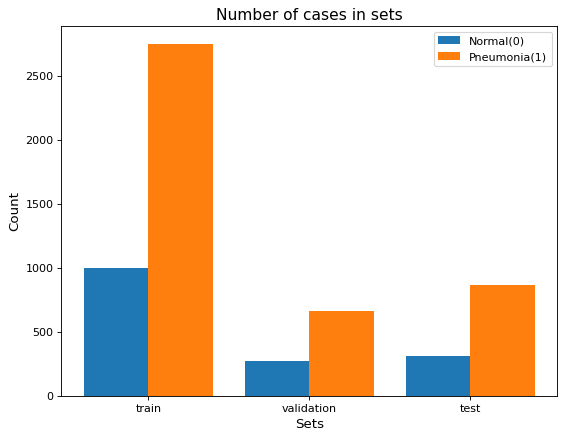

In [7]:
# Plot the results 
print('CNN')
plot_dataset([COUNT_NORMAL_train_CNN, COUNT_NORMAL_val_CNN, COUNT_NORMAL_test_CNN], [COUNT_PNEUMONIA_train_CNN, COUNT_PNEUMONIA_val_CNN, COUNT_PNEUMONIA_test_CNN], ['train', 'validation', 'test'])

Convert the filenames into a dataset.

In [8]:
train_list_ds_CNN = tf.data.Dataset.from_tensor_slices(train_filenames_CNN)
val_list_ds_CNN = tf.data.Dataset.from_tensor_slices(val_filenames_CNN)
test_list_ds_CNN = tf.data.Dataset.from_tensor_slices(test_filenames_CNN)

print('Some examples: \n')
for f in train_list_ds_CNN.take(5):
    print(f.numpy())

Some examples: 

b'scaled_chest_xray/train/PNEUMONIA/BACTERIA-7942103-0003.jpeg'
b'scaled_chest_xray/train/PNEUMONIA/BACTERIA-3149471-0001.jpeg'
b'scaled_chest_xray/train/PNEUMONIA/BACTERIA-4719778-0002.jpeg'
b'scaled_chest_xray/train/NORMAL/NORMAL-4178405-0002.jpeg'
b'scaled_chest_xray/train/PNEUMONIA/BACTERIA-2172741-0002.jpeg'


2023-01-10 00:02:15.212169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lukas/anaconda3/envs/PneumoniaDetectionTensorflow/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-10 00:02:15.212380: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-10 00:02:15.212407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps13-archlinux): /proc/driver/nvidia/version does not exist
2023-01-10 00:02:15.213828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in ot

In [9]:
TRAIN_IMG_COUNT_CNN = tf.data.experimental.cardinality(train_list_ds_CNN).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT_CNN))

VAL_IMG_COUNT_CNN = tf.data.experimental.cardinality(val_list_ds_CNN).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT_CNN))

TEST_IMG_COUNT_CNN = tf.data.experimental.cardinality(test_list_ds_CNN).numpy()
print("Testing images count: " + str(TEST_IMG_COUNT_CNN) + '\n\n')

Training images count: 3747
Validating images count: 937
Testing images count: 1172




We already know that there are only two class names.

In [10]:
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]
CLASS_NAMES

['NORMAL', 'PNEUMONIA']

Currently our dataset is just a list of filenames.In CNN we want to map each filename to the corresponding (image, label) pair. The following methods will help us do that.

As we only have two labels, we will rewrite the label so that 1 or True indicates pneumonia and 0 or False indicates normal.


In [11]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

In [12]:
'''
Function that applies Gaussian Noise to the images.
'''
def add_gaussian_noise(img):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=(200)/(255), dtype=tf.float32)
        noise_img = img + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img

In [13]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # For keeping only a portion of the image
    img = tf.image.central_crop(img, IMAGE_CROP)
    # For adding some noise
    #img = add_gaussian_noise(img)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)

The following method gets the image and the label from the path.

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
train_ds_CNN = train_list_ds_CNN.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds_CNN = val_list_ds_CNN.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_CNN = test_list_ds_CNN.map(process_path, num_parallel_calls=AUTOTUNE)

Image shape:  (180, 180, 3)
Label:  True


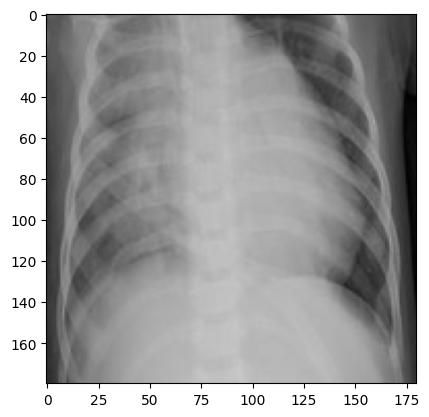

In [16]:
for image, label in train_ds_CNN.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image)

# 3. Visualize the dataset

Let's use buffered prefetching so we can yield data from disk without having I/O become blocking.

In [17]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
      if isinstance(cache, str):
          ds = ds.cache(cache)
      else:
          ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [18]:
train_ds_CNN = prepare_for_training(train_ds_CNN)
val_ds_CNN = prepare_for_training(val_ds_CNN)
test_ds_CNN = test_ds_CNN.batch(BATCH_SIZE)

image_batch_CNN, label_batch_CNN = next(iter(train_ds_CNN))

2023-01-10 00:02:17.060109: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

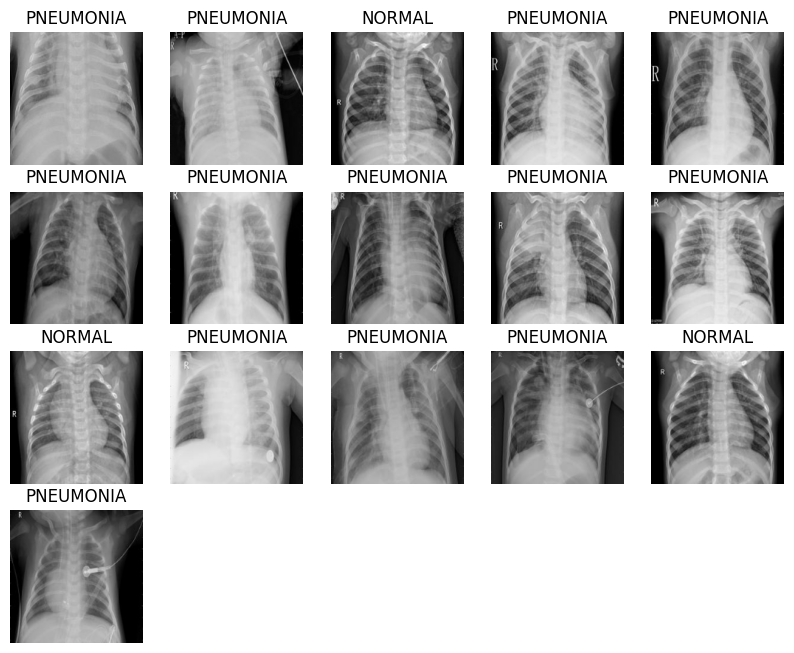

In [20]:
show_batch(image_batch_CNN.numpy(), label_batch_CNN.numpy())

# 4. Build the CNN

To make our model more modular and easier to understand, let's define some blocks. As we're building a convolution neural network, we'll create a convolution block and a dense layer block.

The architecture for this CNN has been inspired by this article.

Convolutional block is composed of of two separable convolution layers, max-pooling and batch-normalization.

In [21]:
def conv_block(filters):
  block = tf.keras.Sequential([
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D()
  ]
  )

  return block

The dense block is built using a dense layer, a batch normalization and a dropout.

In [22]:
def dense_block(units, dropout_rate):
  block = tf.keras.Sequential([
      tf.keras.layers.Dense(units, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(dropout_rate)
  ])
  
  return block

The model is built using an input layer, two convolutional layers and a MaxPooling one. The following structure is composed of convolutional blocks, dropout layers (to reduce overfitting), a flatten layer, three dense blocks and finally a dense layer.

The following method will define the function to build our model for us. The Dropout layers are important as they "drop out," hence the name, certain nodes to reduce the likelikhood of the model overfitting. We want to end the model with a Dense layer of one node, as this will be the output that determines if an X-ray shows an image of pneumonia.

In [23]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model


# 4. Train the model

Since there are only two possible labels for the image, we will be using the binary_crossentropy loss. When we fit the model, identify the class weights. Because we are using a TPU, training will be relatively quick.

For our metrics, we want to include precision and recall as they will provide use with a more informed picture of how good our model is. Accuracy tells us what fractions are the labels are correct. Since our data is not balanced, accuracy might give a skewed sense of a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not a good model).

In the following part of the code we build our model, define the metrics that should be used to evaluate it, we define the optimizer and the loss function. The activation function are ReLU throughout except for the last layer where it is Sigmoid, as this is a binary classification problem.


In [24]:

model = build_model()

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
)



In [25]:
history = model.fit(
    train_ds_CNN,
    steps_per_epoch=TRAIN_IMG_COUNT_CNN // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds_CNN,
    validation_steps=VAL_IMG_COUNT_CNN // BATCH_SIZE
)

Epoch 1/25
117/117 [==============================] - 46s 357ms/step - loss: 0.4748 - accuracy: 0.7989 - precision: 0.9278 - recall: 0.7869 - val_loss: 0.6792 - val_accuracy: 0.7080 - val_precision: 0.7080 - val_recall: 1.0000
Epoch 2/25
117/117 [==============================] - 38s 322ms/step - loss: 0.2212 - accuracy: 0.9244 - precision: 0.9586 - recall: 0.9373 - val_loss: 1.0395 - val_accuracy: 0.7069 - val_precision: 0.7069 - val_recall: 1.0000
Epoch 3/25
117/117 [==============================] - 38s 322ms/step - loss: 0.1955 - accuracy: 0.9308 - precision: 0.9520 - recall: 0.9538 - val_loss: 1.1107 - val_accuracy: 0.7069 - val_precision: 0.7069 - val_recall: 1.0000
Epoch 4/25
117/117 [==============================] - 37s 319ms/step - loss: 0.1691 - accuracy: 0.9407 - precision: 0.9579 - recall: 0.9614 - val_loss: 1.2485 - val_accuracy: 0.7080 - val_precision: 0.7080 - val_recall: 1.0000
Epoch 5/25
117/117 [==============================] - 37s 319ms/step - loss: 0.1555 - accura

## Training Results Plotting

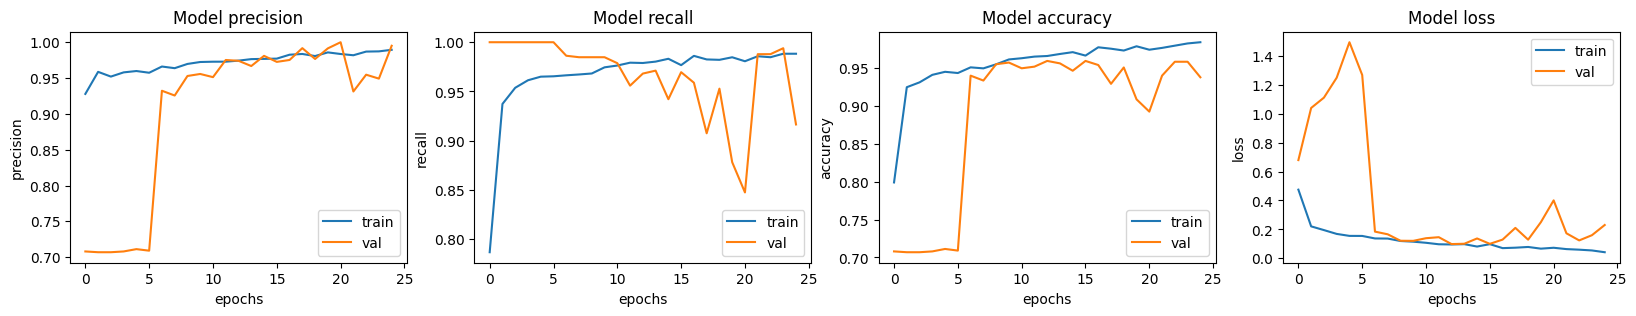

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### Test Results

In [29]:
loss, acc, prec, rec = model.evaluate(test_ds_CNN)

37/37 [==============================] - 4s 117ms/step - loss: 0.2131 - accuracy: 0.9403 - precision: 0.9975 - recall: 0.9210


KeyError: 'binary_accuracy'

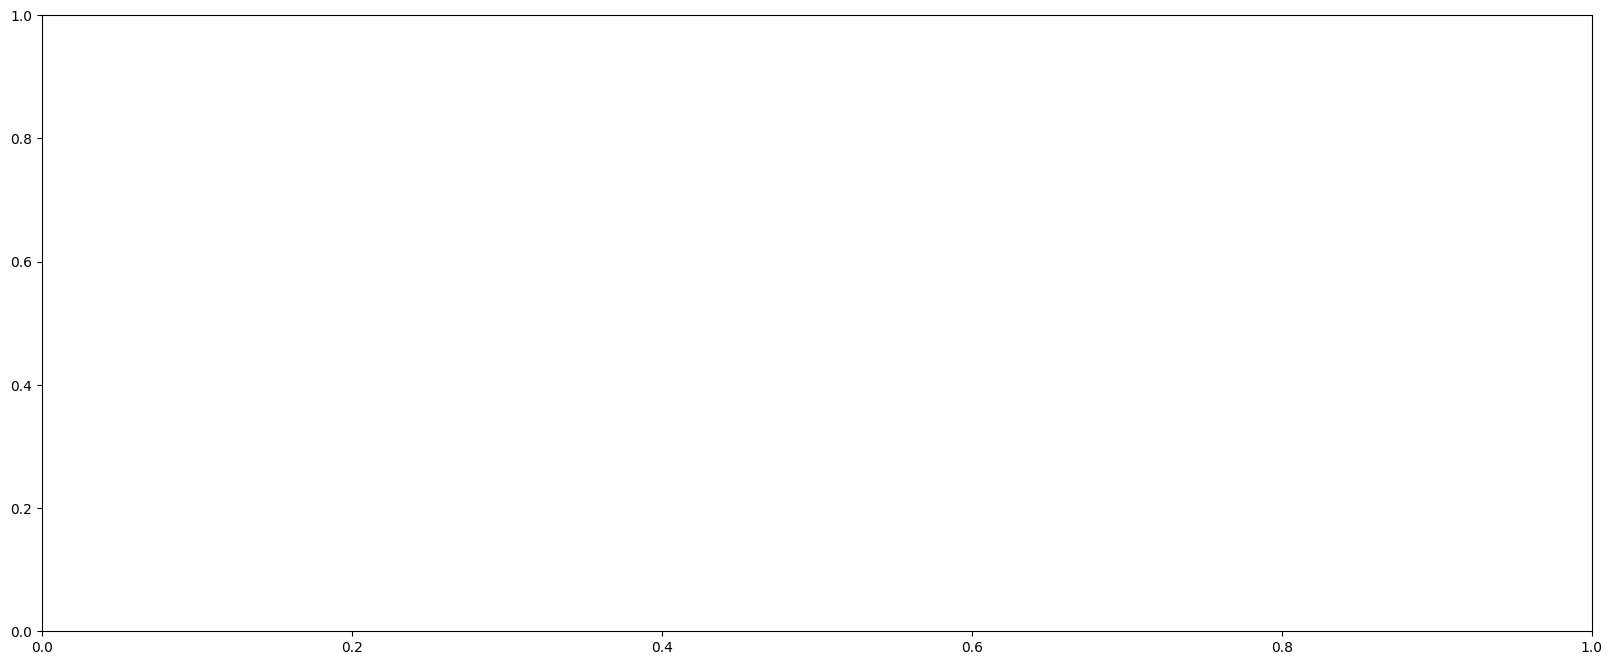

In [30]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [31]:
score = model.evaluate(val_ds, steps = len(val_ds), verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

NameError: name 'val_ds' is not defined

## Model performance and evaluation of results

### Training Results Plotting

Let's plot the model accuracy and loss for the training and the validating set. These plots show the accuracy and loss values for the second round of training.

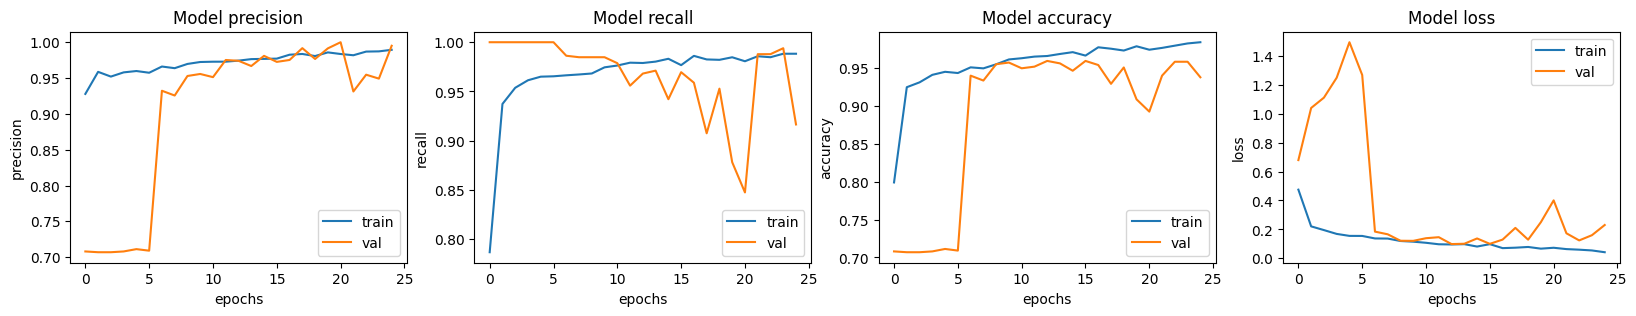

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
# Get predictions
preds_CNN = model.predict_classes(test_ds_CNN, batch_size=16)

AttributeError: 'Sequential' object has no attribute 'predict_classes'

Get the original labels of the images.

In [ ]:
#Get the original labels of each image
orig_test_labels = []
for image, label in test_ds_CNN.as_numpy_iterator():
    for x in label:
        orig_test_labels.append(x)
print(np.array(orig_test_labels).shape)
print(np.array(preds_CNN).shape)

(1172,)


NameError: name 'preds_CNN' is not defined

The **confusion matrix** is convinient to understand the how the predictions went.

In [ ]:
# Get the confusion matrix
cm_CNN  = confusion_matrix(orig_test_labels, preds_CNN)
plt.figure()
plot_confusion_matrix(cm_CNN,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [ ]:
loss_CNN, acc_CNN, prec_CNN, rec_CNN = model.evaluate(test_ds_CNN)

In [ ]:
print('Evaluate function calculating...')
print("Recall of the model is {:.3f}".format(rec_CNN))
print("Precision of the model is {:.3f}".format(prec_CNN))

# Checking if the results are correct by manually calculating Precision and Recall with confusion matrix results
print('\nManually calculating...')
tn, fp, fn, tp = cm_CNN.ravel()

precision_CNN = tp/(tp+fp)
recall_CNN = tp/(tp+fn)

print("Recall of the model is {:.3f}".format(recall_CNN))
print("Precision of the model is {:.3f}".format(precision_CNN))